# Multi Intent Classification

## Problem Statement
>In real-world conversations, especially in chatbots and virtual assistants, users often express multiple intents in a single query. For example:

“Book me a flight and check the weather in Delhi.”

“Play some music and set a reminder for 7 PM.”

* Traditional intent classification models are single-label, meaning they can only detect one intent at a time. This limitation causes them to miss additional intents, leading to incomplete or incorrect responses.

* The challenge is to build a multi-intent classification model that can:

* Accurately identify multiple intents from a single user utterance.

* Handle variations in natural language (different phrasing, synonyms, spelling errors).

* Scale to multiple domains and integrate with downstream applications (chatbots, assistants, customer support systems).

* The goal of this project is to develop a robust NLP-based multi-intent classifier that improves the accuracy and usability of conversational AI        systems, making interactions more natural and effective.

### Approach
1. problem definition
2. Data
3. Evaluation
4. Features
5. Modelling
6. Experimentation

! pip install autocorrect

### Importing essential Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import string
import time


from sklearn.preprocessing import MultiLabelBinarizer
from collections import Counter
from bs4 import BeautifulSoup
from textblob import TextBlob
from autocorrect import Speller

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

import torch
from transformers import BertTokenizer, BertModel

C:\Users\bhave\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Importing data

In [3]:
df = pd.read_csv("customer_support_dataset.csv")

In [ ]:
from google.colab import files
uploaded=files.upload()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Data Understanding & Preprocessing

In [4]:
df

,flags,instruction,category,intent,response
0,B,question about cancelling order {{Order Number}},ORDER,cancel_order,I've understood you have a question regarding ...
1,BQZ,i have a question about cancelling oorder {{Or...,ORDER,cancel_order,I've been informed that you have a question ab...
2,BLQZ,i need help cancelling puchase {{Order Number}},ORDER,cancel_order,I can sense that you're seeking assistance wit...
3,BL,I need to cancel purchase {{Order Number}},ORDER,cancel_order,I understood that you need assistance with can...
4,BCELN,"I cannot afford this order, cancel purchase {{...",ORDER,cancel_order,I'm sensitive to the fact that you're facing f...
...,...,...,...,...,...
26867,BL,I am waiting for a rebate of {{Refund Amount}}...,REFUND,track_refund,Thank you for sharing your situation regarding...
26868,BIL,how to see if there is anything wrong with my ...,REFUND,track_refund,Ensuring the accuracy of your restitution is o...
26869,BLQZ,I'm waiting for a reimbjrsement of {{Currency ...,REFUND,track_refund,"Firstly, I genuinely understand the importance..."
26870,BL,I don't know what to do to see my reimbursemen...,REFUND,track_refund,I've understood you're unsure about how to che...


In [5]:
df.sample(100)

,flags,instruction,category,intent,response
26385,BIL,can you show me the compensation status?,REFUND,track_refund,For sure! I'd be happy to assist you with chec...
2530,BLQZ,i dont know whatto do to modify my address,SHIPPING,change_shipping_address,"No worries, I'm here to help you with modifyin..."
10520,BM,give me information about creating pro accounts,ACCOUNT,create_account,Of course! I'm delighted to provide you with t...
1,BQZ,i have a question about cancelling oorder {{Or...,ORDER,cancel_order,I've been informed that you have a question ab...
3493,BLM,I want assistance checking the early terminati...,CANCEL,check_cancellation_fee,Of course! I'm here to help you with checking ...
...,...,...,...,...,...
20106,BL,I need assistance resetting the PIN of my profile,ACCOUNT,recover_password,Of course! I'm here to help you reset the PIN ...
10814,BIQ,where to create a gold account,ACCOUNT,create_account,Fantastic! I'm thrilled that you're interested...
4356,BL,I want help taking a quick look at bill #85632,INVOICE,check_invoice,Absolutely! I understand that you're seeking a...
12249,BLMQ,need help checking what shipment options I have,DELIVERY,delivery_options,I'll get right on it! Let's dive into the worl...


In [6]:
df.shape

(26872, 5)

In [7]:
df.dtypes

flags          object
instruction    object
category       object
intent         object
response       object
dtype: object

In [8]:
df.describe()

,flags,instruction,category,intent,response
count,26872,26872,26872,26872,26872
unique,394,24635,11,27,26870
top,BL,is it possible to place an order from {{Delive...,ACCOUNT,contact_customer_service,"Firstly, I truly understand how pivotal the {{..."
freq,5212,8,5986,1000,2


In [9]:
df.isnull().sum()

flags          0
instruction    0
category       0
intent         0
response       0
dtype: int64

In [10]:
df['flags'].value_counts()

flags
BL        5212
BLQ       2467
BIL       2138
BLM       1297
BILQ      1057
          ... 
BIPQWZ       1
BENQWZ       1
BPQWZ        1
BKQZ         1
BELMNW       1
Name: count, Length: 394, dtype: int64

In [11]:
df['category'].value_counts()

category
ACCOUNT         5986
ORDER           3988
REFUND          2992
CONTACT         1999
INVOICE         1999
PAYMENT         1998
FEEDBACK        1997
DELIVERY        1994
SHIPPING        1970
SUBSCRIPTION     999
CANCEL           950
Name: count, dtype: int64

In [12]:
df['intent'].value_counts()

intent
contact_customer_service    1000
complaint                   1000
check_invoice               1000
switch_account              1000
edit_account                1000
contact_human_agent          999
check_payment_methods        999
delivery_period              999
newsletter_subscription      999
get_invoice                  999
payment_issue                999
registration_problems        999
cancel_order                 998
place_order                  998
track_refund                 998
change_order                 997
set_up_shipping_address      997
check_refund_policy          997
create_account               997
get_refund                   997
review                       997
delivery_options             995
delete_account               995
recover_password             995
track_order                  995
change_shipping_address      973
check_cancellation_fee       950
Name: count, dtype: int64

In [13]:
# Basic info
print(df.info())
print("\nMissing values:\n", df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26872 entries, 0 to 26871
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   flags        26872 non-null  object
 1   instruction  26872 non-null  object
 2   category     26872 non-null  object
 3   intent       26872 non-null  object
 4   response     26872 non-null  object
dtypes: object(5)
memory usage: 1.0+ MB
None

Missing values:
 flags          0
instruction    0
category       0
intent         0
response       0
dtype: int64


In [14]:
df["intent"] = df["intent"].apply(lambda x: x.strip().lower() if isinstance(x, str) else x)

In [15]:
df['intent'].describe()

count                        26872
unique                          27
top       contact_customer_service
freq                          1000
Name: intent, dtype: object

In [16]:
df['intent'] = df['intent'].apply(lambda x: BeautifulSoup(x, "html.parser").get_text() if isinstance(x, str) else x)

In [17]:
exclude=string.punctuation
def remove_punc(text):
  for char in exclude:
    text=text.replace(char,'')
  return text

In [18]:
df['instruction'] = df['instruction'].apply(lambda x: remove_punc(x) if isinstance(x, str) else x)

In [19]:
df['response'] = df['response'].apply(lambda x: remove_punc(x) if isinstance(x, str) else x)

In [20]:
df['category'] = df['category'].apply(lambda x: remove_punc(x) if isinstance(x, str) else x)

In [21]:
df['intent'] = df['intent'].apply(lambda x: remove_punc(x) if isinstance(x, str) else x)

In [22]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['instruction'] = df['instruction'].apply(clean_text)
df['instruction'].sample(10)

16199        want help obtaining reimbursements ofmy money
12227    is it possibleto place an order from delivery ...
25700                         status of order order number
16222              i want help to request rebates of money
11021    would it be possible to delete a account categ...
11679    i dont know how i can delete the freemium account
1330                    help to correct order order number
14461            updating data on account category account
20728    i dont know what i have to do to erset my user...
22292    i need to write an opinion about an service ho...
Name: instruction, dtype: object

In [23]:
df['instruction'] = df['instruction'].apply(lambda x: BeautifulSoup(x, "html.parser").get_text() if isinstance(x, str) else x)

In [24]:
df['response'] = df['response'].str.lower()
df['response'].sample(10)


6084     ill get right on it i completely understand yo...
21009    we appreciate your inquiry about how to report...
2523     for sure if you need to modify your shopping a...
14909    i certainly recognize your concern about not b...
8101     thank you for reaching out i understand your n...
3732     sure i can help you with that to see the termi...
9101     thanks for getting in touch i grasp that youre...
1052     i completely understand your need to change an...
7994     your reachout is appreciated im sensing that y...
5294     i appreciate your interest in learning how to ...
Name: response, dtype: object

In [25]:
df['response'] = df['response'].apply(lambda x: BeautifulSoup(x, "html.parser").get_text() if isinstance(x, str) else x)

In [26]:
df['category'] = df['category'].apply(lambda x: BeautifulSoup(x, "html.parser").get_text() if isinstance(x, str) else x)

In [27]:
# Removing URLS
def remove_urls(text):
    pattern = re.compile(r'https?://\S+|www\.\S+')
    return pattern.sub(r'', text)

In [28]:
df['response'] = df['response'].apply(lambda x: remove_urls(x) if isinstance(x, str) else x)

In [29]:
df['instruction'] = df['instruction'].apply(lambda x: remove_urls(x) if isinstance(x, str) else x)

In [30]:
df['category'] = df['category'].apply(lambda x: remove_urls(x) if isinstance(x, str) else x)

In [31]:
df['intent'] = df['intent'].apply(lambda x: remove_urls(x) if isinstance(x, str) else x)

In [ ]:
df.groupby(['intent', 'flags']).size().reset_index(name='count').sort_values('count',ascending=False)

In [34]:
df.head(10)

,flags,instruction,category,intent,response
0,B,question about cancelling order order number,ORDER,cancelorder,ive understood you have a question regarding c...
1,BQZ,i have a question about cancelling oorder orde...,ORDER,cancelorder,ive been informed that you have a question abo...
2,BLQZ,i need help cancelling puchase order number,ORDER,cancelorder,i can sense that youre seeking assistance with...
3,BL,i need to cancel purchase order number,ORDER,cancelorder,i understood that you need assistance with can...
4,BCELN,i cannot afford this order cancel purchase ord...,ORDER,cancelorder,im sensitive to the fact that youre facing fin...
5,BI,can you help me cancel order order number,ORDER,cancelorder,of course im here to assist you in canceling y...
6,BCLN,i can no longer afford order order number canc...,ORDER,cancelorder,i pick up what youre putting down that youre i...
7,BL,i am trying to cancel purchase order number,ORDER,cancelorder,ive understood that youre seeking assistance i...
8,BL,i have got to cancel purchase order number,ORDER,cancelorder,im sensitive to the fact that youre seeking as...
9,BLQ,i need help canceling purchase order number,ORDER,cancelorder,i perceive that youre seeking assistance with ...


# Exploratory Data Analysis (EDA)

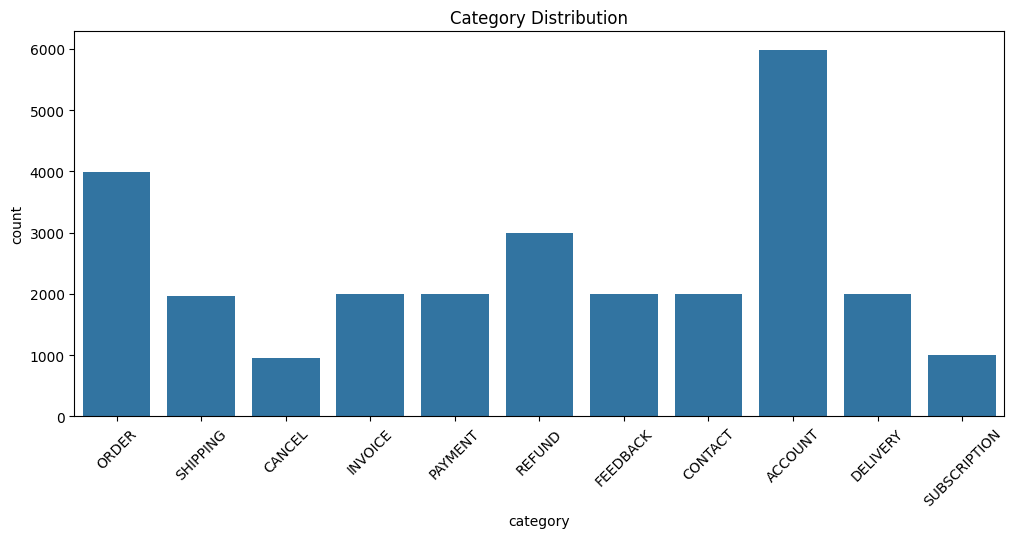

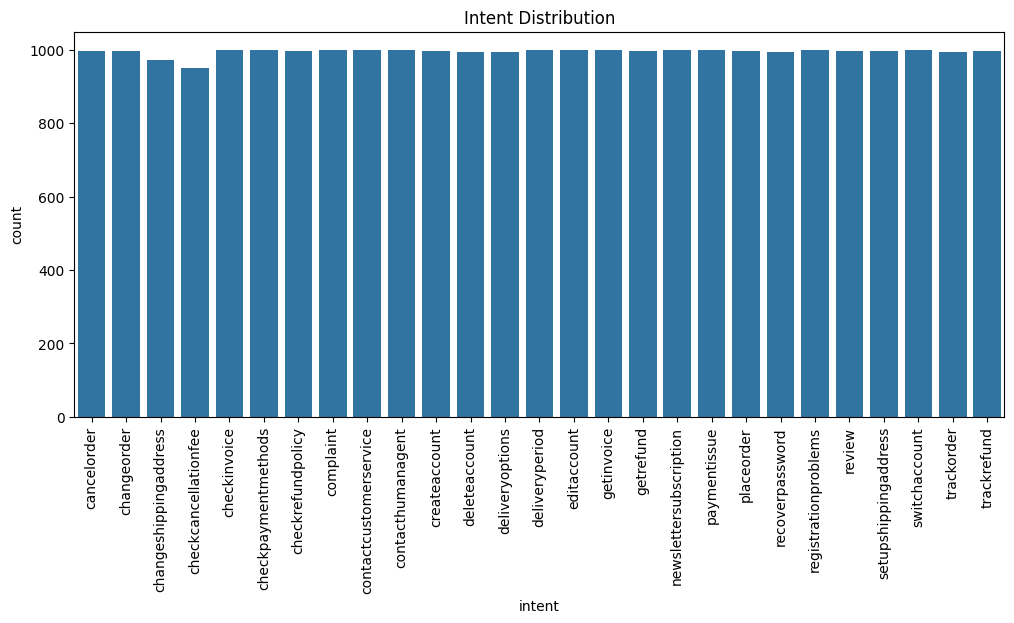

In [35]:
# Distribution of categories and intents
plt.figure(figsize=(12,5))
sns.countplot(data=df, x='category')
plt.title('Category Distribution')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12,5))
sns.countplot(data=df, x='intent')
plt.title('Intent Distribution')
plt.xticks(rotation=90)
plt.show()

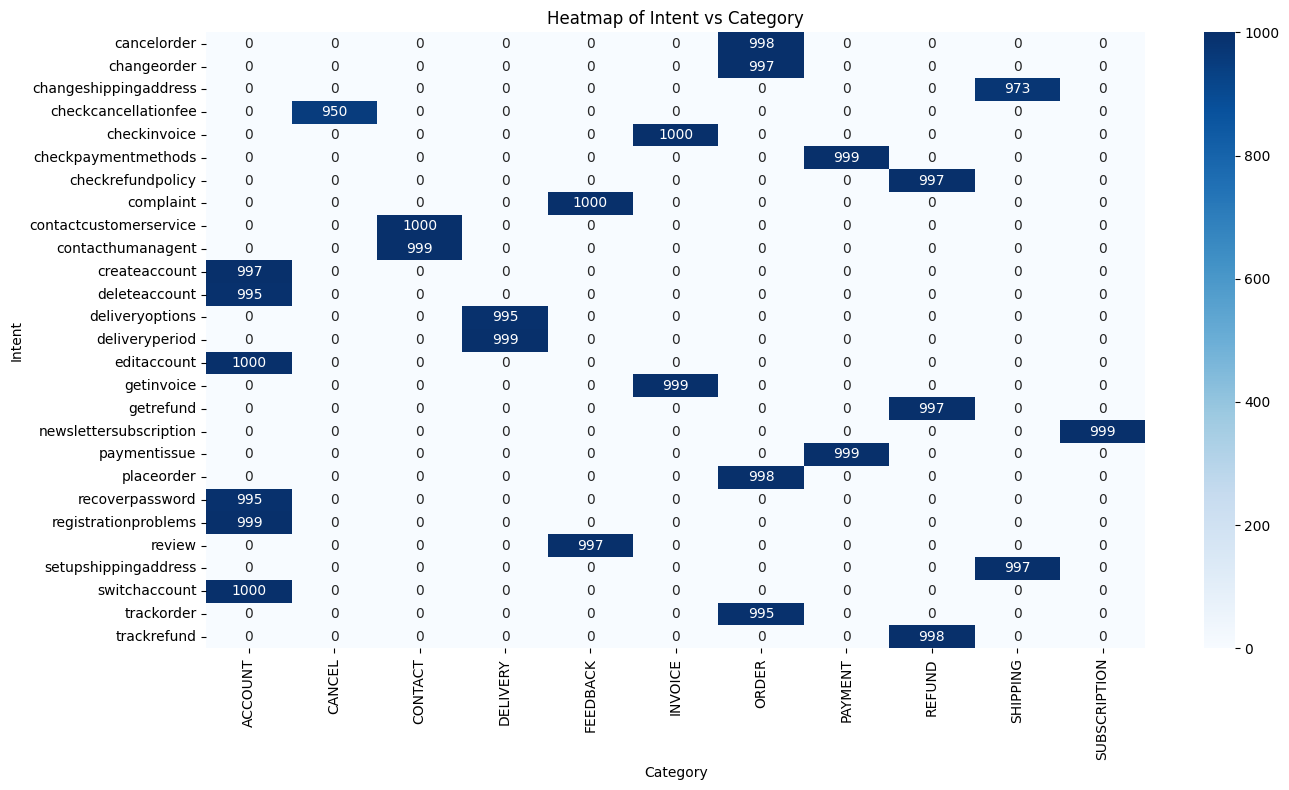

In [36]:
pivot_table = df.groupby(['intent', 'category']).size().unstack(fill_value=0)

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(pivot_table, annot=True, fmt='d', cmap='Blues')
plt.title("Heatmap of Intent vs Category")
plt.xlabel("Category")
plt.ylabel("Intent")
plt.tight_layout()
plt.show()

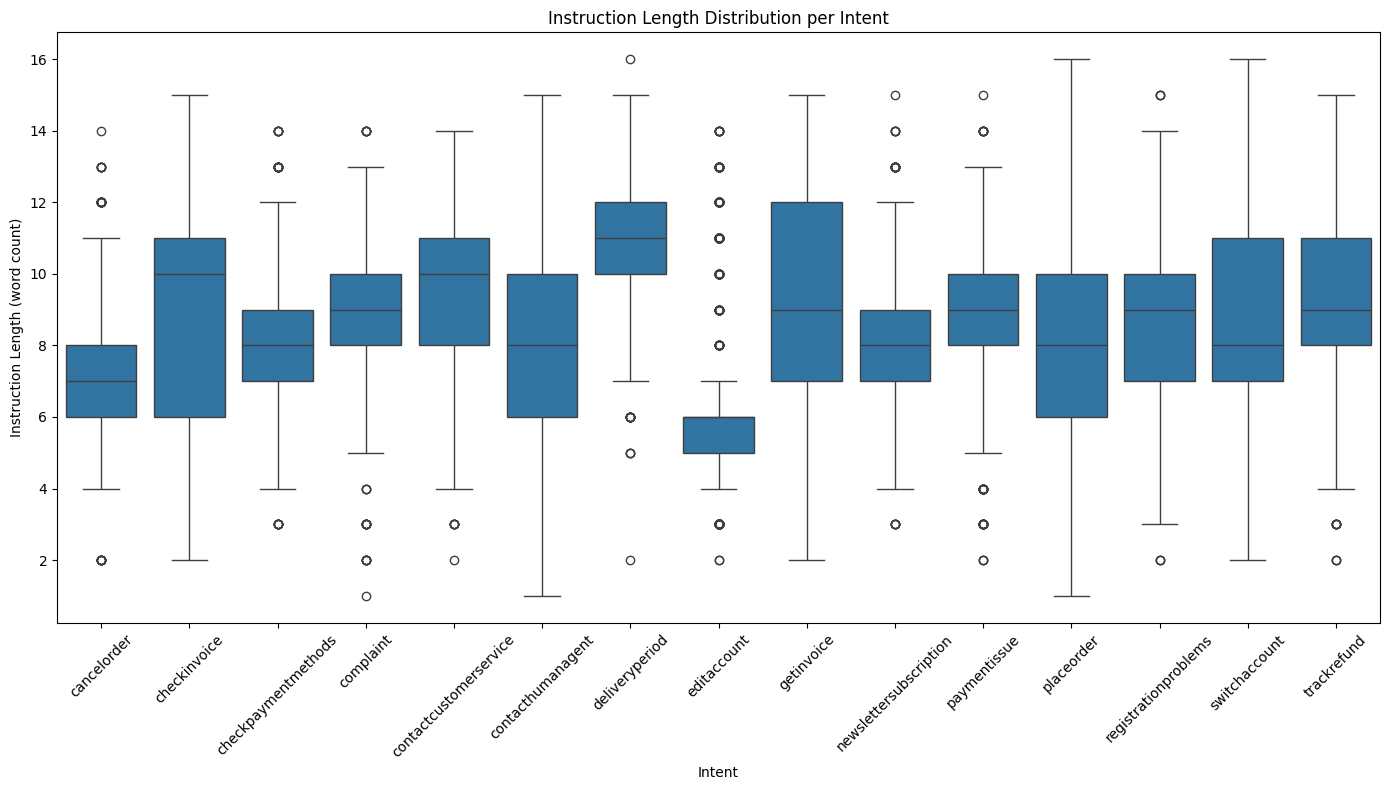

In [38]:
df['instruction_length'] = df['instruction'].apply(lambda x: len(str(x).split()))

top_intents = df['intent'].value_counts().head(15).index
filtered_df = df[df['intent'].isin(top_intents)]

plt.figure(figsize=(14, 8))
sns.boxplot(data=filtered_df, x='intent', y='instruction_length')
plt.title("Instruction Length Distribution per Intent")
plt.xlabel("Intent")
plt.ylabel("Instruction Length (word count)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

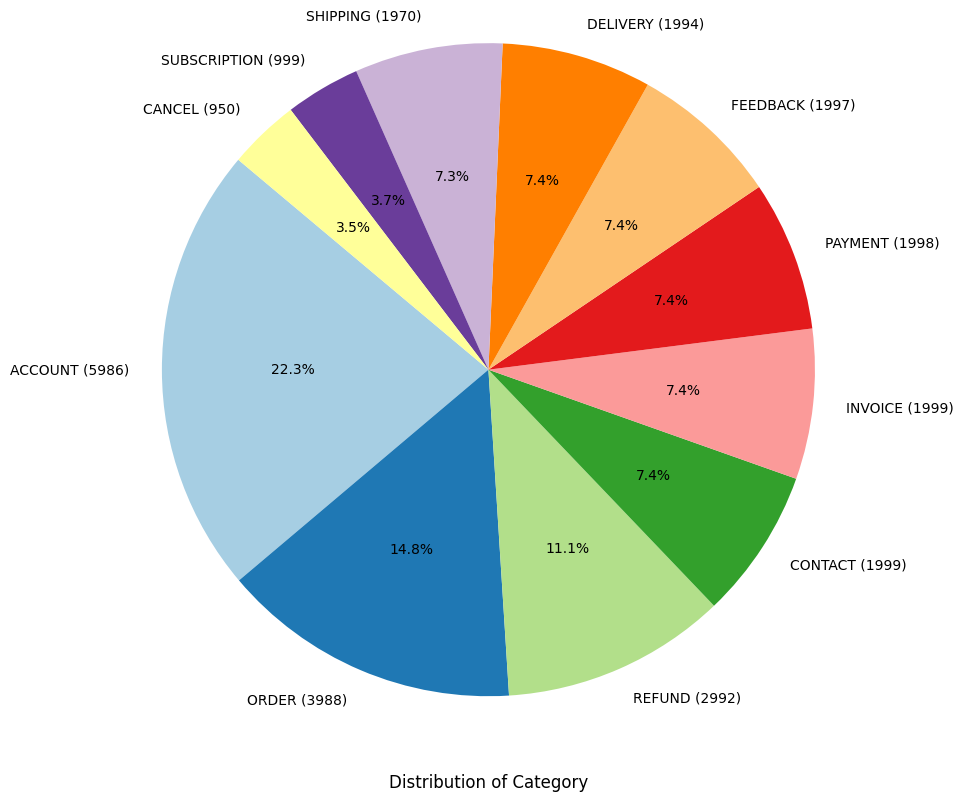

In [39]:
category_counts = df['category'].value_counts()

# Create the pie chart
plt.figure(figsize=(10, 8))
plt.pie(
    category_counts,
    labels=[f'{category} ({count})' for category, count in zip(category_counts.index, category_counts.values)],
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Paired.colors
)
plt.title("Distribution of Category", y=-0.1)
plt.axis('equal')
plt.tight_layout()
plt.show()

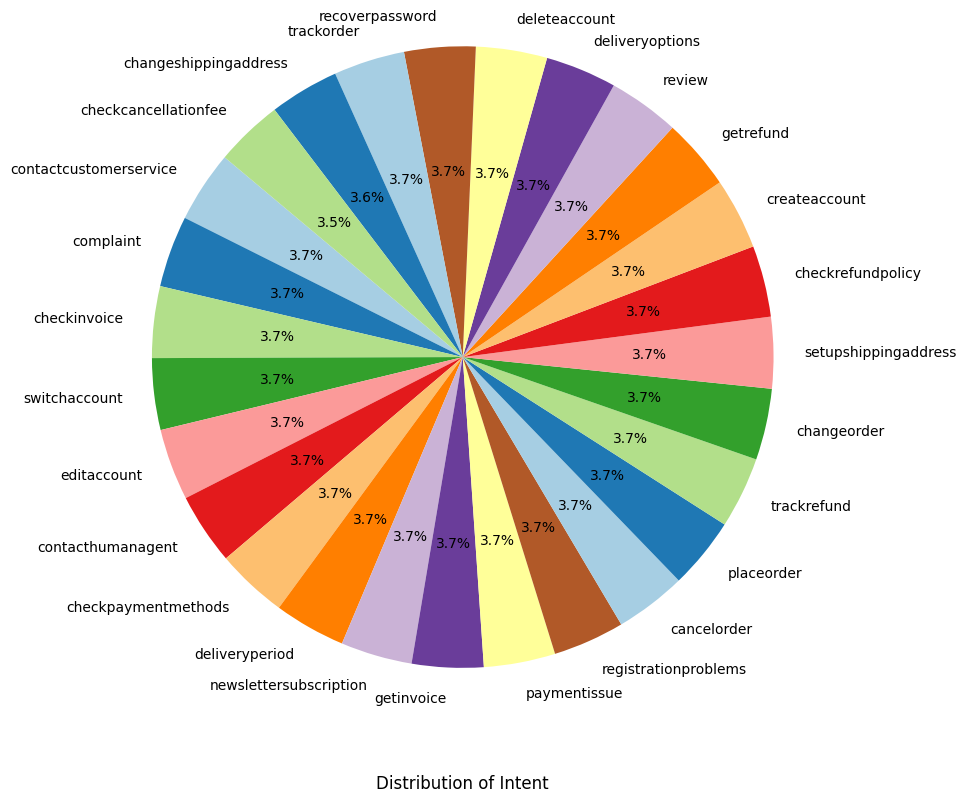

In [40]:
category_counts = df['intent'].value_counts()

plt.figure(figsize=(10, 8))
plt.pie(
    category_counts,
    labels=category_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Paired.colors
)
plt.title("Distribution of Intent", y=-0.15)
plt.axis('equal')
plt.tight_layout()
plt.show()

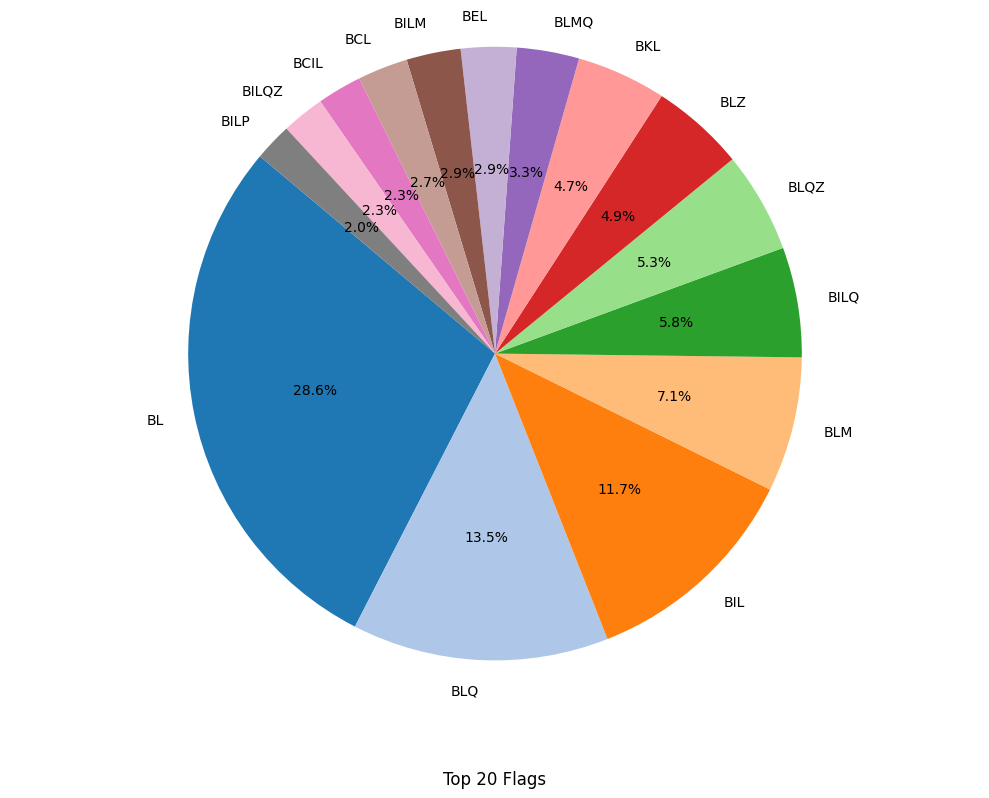

In [41]:
top_flags = df['flags'].value_counts().head(15)

plt.figure(figsize=(10, 8))
plt.pie(
    top_flags,
    labels=top_flags.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.tab20.colors
)
plt.title("Top 20 Flags", y=-0.15)
plt.axis('equal')
plt.tight_layout()
plt.show()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'checkrefundpolicy'),
  Text(1, 0, 'contactcustomerservice'),
  Text(2, 0, 'complaint'),
  Text(3, 0, 'newslettersubscription'),
  Text(4, 0, 'setupshippingaddress'),
  Text(5, 0, 'changeshippingaddress'),
  Text(6, 0, 'checkpaymentmethods'),
  Text(7, 0, 'contacthumanagent'),
  Text(8, 0, 'deliveryperiod'),
  Text(9, 0, 'editaccount')])

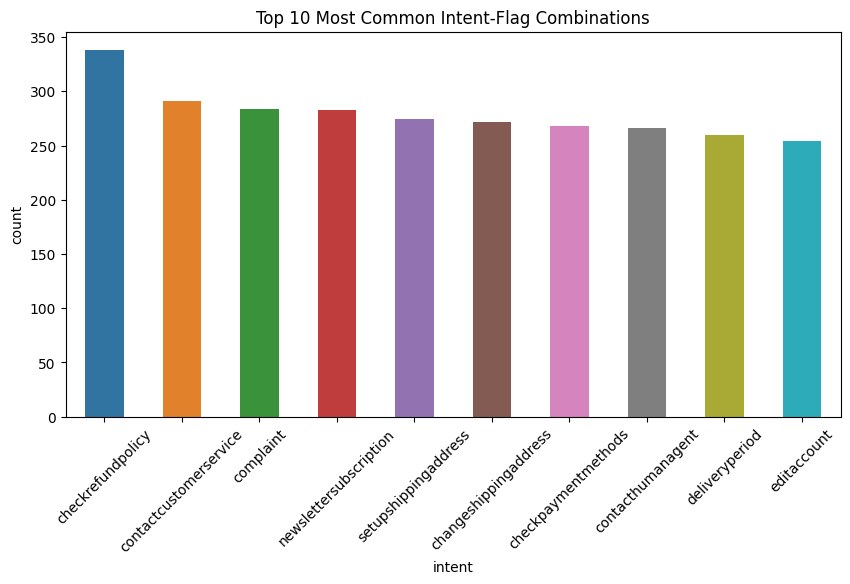

In [42]:
grouped=df.groupby(['intent', 'flags']).size().reset_index(name='count').sort_values('count',ascending=False).head(10)

plt.figure(figsize=(10, 5))
sns.barplot(data=grouped, x='intent', y='count', hue='intent',width=0.5)
plt.title('Top 10 Most Common Intent-Flag Combinations')
plt.xticks(rotation=45)

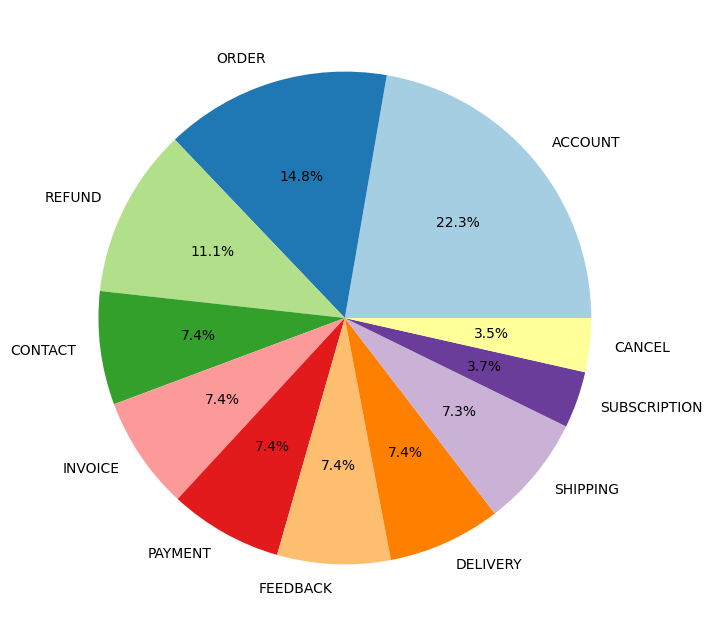

In [43]:
counts = df["category"].value_counts()
plt.figure(figsize=(12, 8))
pie = plt.pie(counts, labels=counts.index, autopct='%1.1f%%', colors=plt.cm.Paired.colors)
plt.show(pie)

# Feature Extraction


In [44]:
df['category']=df['category'].str.lower()

In [45]:
df['flags']=df['flags'].str.lower()

In [46]:
df.head()

,flags,instruction,category,intent,response,instruction_length
0,b,question about cancelling order order number,order,cancelorder,ive understood you have a question regarding c...,6
1,bqz,i have a question about cancelling oorder orde...,order,cancelorder,ive been informed that you have a question abo...,9
2,blqz,i need help cancelling puchase order number,order,cancelorder,i can sense that youre seeking assistance with...,7
3,bl,i need to cancel purchase order number,order,cancelorder,i understood that you need assistance with can...,7
4,bceln,i cannot afford this order cancel purchase ord...,order,cancelorder,im sensitive to the fact that youre facing fin...,9


In [47]:
# Encode the target labels (intent)
le = LabelEncoder()
df['intent_label'] = le.fit_transform(df['intent'])
label_map = dict(zip(le.classes_, le.transform(le.classes_)))
label_map

{'cancelorder': np.int64(0),
 'changeorder': np.int64(1),
 'changeshippingaddress': np.int64(2),
 'checkcancellationfee': np.int64(3),
 'checkinvoice': np.int64(4),
 'checkpaymentmethods': np.int64(5),
 'checkrefundpolicy': np.int64(6),
 'complaint': np.int64(7),
 'contactcustomerservice': np.int64(8),
 'contacthumanagent': np.int64(9),
 'createaccount': np.int64(10),
 'deleteaccount': np.int64(11),
 'deliveryoptions': np.int64(12),
 'deliveryperiod': np.int64(13),
 'editaccount': np.int64(14),
 'getinvoice': np.int64(15),
 'getrefund': np.int64(16),
 'newslettersubscription': np.int64(17),
 'paymentissue': np.int64(18),
 'placeorder': np.int64(19),
 'recoverpassword': np.int64(20),
 'registrationproblems': np.int64(21),
 'review': np.int64(22),
 'setupshippingaddress': np.int64(23),
 'switchaccount': np.int64(24),
 'trackorder': np.int64(25),
 'trackrefund': np.int64(26)}

In [50]:
# Clean instructions
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text.strip()

df['clean_instruction'] = df['instruction'].apply(clean_text)
df['intent_list'] = df['intent'].apply(lambda x: [i.strip() for i in x.split(',')])


# Model Building

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, hamming_loss, f1_score, accuracy_score


In [54]:
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(df['intent_list'])

vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1,2))  # use n-grams
X = vectorizer.fit_transform(df['clean_instruction'])

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

In [55]:
model = OneVsRestClassifier(LogisticRegression(max_iter=1000))
model.fit(X_train, Y_train)


,estimator,LogisticRegre...max_iter=1000)
,n_jobs,None
,verbose,0
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None


# Model Training & Evaluation


In [56]:
# Predict with sigmoid probabilities and threshold tuning
threshold = 0.2
probs = model.predict_proba(X_test)
Y_pred = (probs >= threshold).astype(int)

print("Hamming Loss:", hamming_loss(Y_test, Y_pred))
print("Micro F1-score:", f1_score(Y_test, Y_pred, average='micro'))
print("Macro F1-score:", f1_score(Y_test, Y_pred, average='macro'))

# Subset accuracy: exact match
subset_acc = accuracy_score(Y_test, Y_pred)
print("Subset Accuracy (Exact Match):", subset_acc)

# Detailed report
print("\nClassification report for top 10 intents:")
print(classification_report(Y_test, Y_pred, target_names=mlb.classes_))


Hamming Loss: 0.0015021533161068046
Micro F1-score: 0.9798967170785688
Macro F1-score: 0.9800499278243024
Subset Accuracy (Exact Match): 0.9650232558139535

Classification report for top 10 intents:
                        precision    recall  f1-score   support

           cancelorder       0.95      0.98      0.97       187
           changeorder       0.90      0.99      0.94       187
 changeshippingaddress       0.98      0.98      0.98       216
  checkcancellationfee       1.00      0.98      0.99       199
          checkinvoice       0.88      0.99      0.93       192
   checkpaymentmethods       1.00      1.00      1.00       206
     checkrefundpolicy       0.99      0.99      0.99       200
             complaint       1.00      1.00      1.00       203
contactcustomerservice       1.00      0.98      0.99       208
     contacthumanagent       0.99      1.00      0.99       201
         createaccount       0.98      0.97      0.98       217
         deleteaccount       0.9

C:\Users\bhave\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


C:\Users\bhave\AppData\Local\Temp\ipykernel_29008\3074313665.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_scores, y=top_labels, palette="Blues_d")


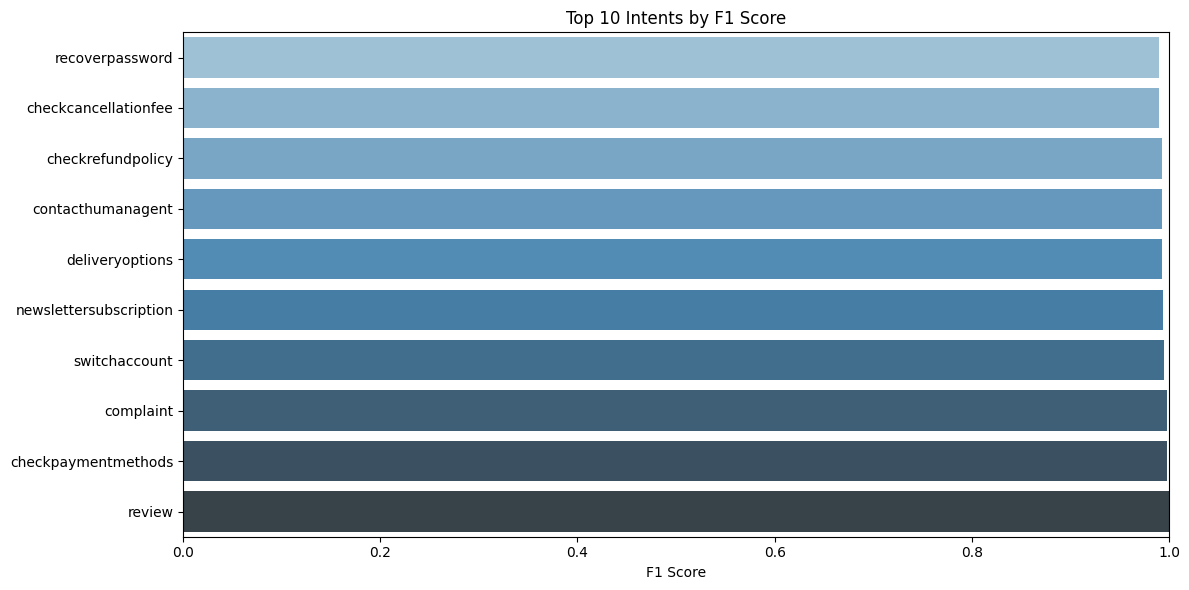

In [57]:
f1_scores = f1_score(Y_test, Y_pred, average=None)
labels = mlb.classes_

# Top 10 intent F1 scores
top_n = 10
top_indices = np.argsort(f1_scores)[-top_n:]
top_labels = [labels[i] for i in top_indices]
top_scores = f1_scores[top_indices]

plt.figure(figsize=(12, 6))
sns.barplot(x=top_scores, y=top_labels, palette="Blues_d")
plt.xlabel("F1 Score")
plt.title(f"Top {top_n} Intents by F1 Score")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

In [59]:
# Test on a new input query using thresholded probabilities
test_query =input("Enter your query:") 
cleaned = clean_text(test_query)
vec = vectorizer.transform([cleaned])

probs = model.predict_proba(vec)

threshold = 0.2
pred_bin = (probs >= threshold).astype(int)

predicted_intents = mlb.inverse_transform(pred_bin)
print("Test Query:", test_query)
print("Predicted intents:", predicted_intents)


Enter your query: I want to recover my password


Test Query: I want to recover my password
Predicted intents: [('recoverpassword',)]


In [ ]:
test_query =input("Enter your query:") 
cleaned = clean_text(test_query)
vec = vectorizer.transform([cleaned])

probs = model.predict_proba(vec)

threshold = 0.2
pred_bin = (probs >= threshold).astype(int)

predicted_intents = mlb.inverse_transform(pred_bin)
print("Test Query:", test_query)
print("Predicted intents:", predicted_intents)
